In [1]:
import nltk
import pickle
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers'))
twenty_test  = fetch_20newsgroups(subset='test' , shuffle=True, remove=('headers', 'footers'))

# Separo en train test y validacion
x_train, x_valid, y_train, y_valid = train_test_split(twenty_train['data'], twenty_train.target, test_size = 0.2, random_state=2)
x_test, y_test = twenty_test['data'], twenty_test.target

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Revision de los datos

In [2]:
print(twenty_train.keys())
print("Cantidad de clases: ",len(twenty_train.target_names))

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
Cantidad de clases:  20


De estos tipos de datos me van a interesar data pq contiene el texto que quiero clasificar y target/target_names que son las clases en las que quiero clasificar los textos

In [3]:
data_len = len(twenty_train['data'])
print('Dataset length:',data_len)

Dataset length: 11314


Guarde el largo de mi dataset

In [4]:
twenty_train['data'][0].split('\n')

['I was wondering if anyone out there could enlighten me on this car I saw',
 'the other day. It was a 2-door sports car, looked to be from the late 60s/',
 'early 70s. It was called a Bricklin. The doors were really small. In addition,',
 'the front bumper was separate from the rest of the body. This is ',
 'all I know. If anyone can tellme a model name, engine specs, years',
 'of production, where this car is made, history, or whatever info you',
 'have on this funky looking car, please e-mail.']

In [5]:
# Podemos observar la proporcion de clases
for i in range(20):
    mask = twenty_train.target == i
    print("Clase {}: {:.4f}%".format(i , mask.sum()/data_len*100))

Clase 0: 4.2425%
Clase 1: 5.1617%
Clase 2: 5.2236%
Clase 3: 5.2148%
Clase 4: 5.1087%
Clase 5: 5.2413%
Clase 6: 5.1706%
Clase 7: 5.2501%
Clase 8: 5.2855%
Clase 9: 5.2766%
Clase 10: 5.3032%
Clase 11: 5.2590%
Clase 12: 5.2236%
Clase 13: 5.2501%
Clase 14: 5.2413%
Clase 15: 5.2943%
Clase 16: 4.8259%
Clase 17: 4.9850%
Clase 18: 4.1100%
Clase 19: 3.3322%


Como se puede observar las clases tienen una distribucion aproximadamente uniforme, por lo tanto el accuracy es una buena metrica para evaluar el modelo de prediccion

Una vez con una idea de los datos podemos empezar a procesar los datos.

## Procesamiento de los datos

Vamos a separar estos textos en palabras individuales (tokenizar), lematizar, quitar las palabras que sean muy repetitivas del idioma y reemplazar algunas palabras por su raiz
Para esto armamos una funcion la cual perimite elegir cual de los tratamientos aplicar a un determinado set de datos de entrada

La lemmatización permite colapsar todas las instancias de una palabra con variaciones en su inflección o modo de uso en un mismo token, reduciendo el conjunto de palabras final y detectando mejor el uso de una misma palabra. En este caso no utilizamos un algoritmo para detectar si palabras con multiples tipos (sustantivo, adjetivo, verbo, adverbio) estan siendo usadas como uno u otro tipo, por lo cual WordNet presume que son sustantivos.

Stemming colapsa aún más las instancias de una palabra llevandolas a la raiz de la misma, usualmente resultando en la aproximación a un concepto base. Por ejemplo, se remueven prefijos, sufijos, etc. La lemmatización previa funciona como un stemming más complejo, y el stemmer utilizado termina de reducir las palabras a su forma más simple.

In [6]:
def treat_data(data, lemm=True, stem=True, stop=True):
    lem = WordNetLemmatizer()
    stemm = PorterStemmer()
    stop_words = stopwords.words('english')
    p_data = [word_tokenize(x) for x in data]
    print("Tokenize ready")
    
    if lemm:
        p_data = [[lem.lemmatize(y) for y in x ] for x in p_data]
        print("Lammatize ready")
    if stop:
        p_data = [[x for x in y if x not in stop_words] for y in p_data]
        print("Stop remove ready")
    if stem:
        p_data = [[stemm.stem(x) for x in y] for y in p_data]
        print("Stemmed ready")
    
    p_data = [[x for x in y if x.isalpha()] for y in p_data]
    print("Finished")
    return [' '.join(x) for x in p_data]

In [7]:
# Cache functions
def save_data(filename, array):
    f = open(filename, 'wb')
    pickle.dump(array, f)
    f.close()

def get_data(filename):
    f = open(filename, 'rb')
    ret = pickle.load(f)
    f.close()
    return ret

Procesamos los datos de train aplicando tokenizacion, lematizacion, stemmer, y sacando las palabras tipicas del lenguaje

In [8]:
x_train_p = treat_data(x_train)
x_valid_p = treat_data(x_valid)

Tokenize ready
Lammatize ready
Stop remove ready
Stemmed ready
Finished
Tokenize ready
Lammatize ready
Stop remove ready
Stemmed ready
Finished


Para continuar con el analisis de los datos vamos a realizar un análisis del document frequency de las palabras, esto sera de utilidad para definir rangos posibles para los valores de max_df y min_df a la hora de armar el vocabulario del modelo.

In [9]:
def vectorizer(data, cv, M_df = 1.0, m_df = 1):
    #instancio un count vectorizer para pasar los strings a vectores
    vector = cv(max_df=M_df, min_df=m_df)
    # Armo el vocabulario
    vector.fit(data)
    print("El largo del vocabulario es:", len(vector.vocabulary_))
    return vector, vector.transform(data)

In [10]:
train_matrix, x_train_v = vectorizer(x_train_p, CountVectorizer)

El largo del vocabulario es: 43007


In [11]:
def get_df(sparse_matrix):
    times = np.array([x.count_nonzero() for x in sparse_matrix.transpose()])
    times_r = times/sparse_matrix.shape[0]
    return times, times_r

def plot_docfreq(absolute, relative, max_a=100, max_r=0.8):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    print("Max document frequency: {}\nMin appearances: {}".format(max(relative), min(absolute)))
    axs[0].hist(absolute, bins=20, range=[0, max_a]) #creamos el gráfico en Seaborn
    axs[1].hist(relative, bins=20, range=[0, max_r]) #creamos el gráfico en Seaborn
    plt.ylabel("# Palabras")
    plt.plot()

In [12]:
test_t, test_tr = get_df(x_train_v)

Max document frequency: 0.5333112363274777
Min appearances: 1


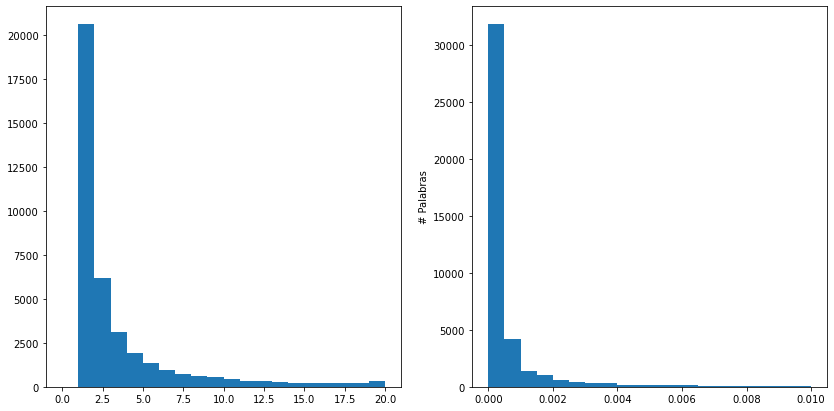

In [13]:
plot_docfreq(test_t, test_tr, 20, 0.01)

In [14]:
x_train_p[1]

'i look good deal follow use new aviat headset mic handheld tranciev may consid com portabl gp loran navig repli call pleas wake night worker hous must call day i understand want employ pay call jay snyder jay gdx uunet compnect gdx jay thi brain unix worldblaz thi brain drug msdo unix msdo file area xenix bin'

In [15]:
(test_tr > 0.01).sum()/len(test_tr)*100

3.622666077615272

Se puede observar que menos hay pocas palabras que aparezcan en más del 1% de los articulos, con lo cual se puede tener una pauta de en torno a que valores variar el max_df, y ademas se puede apreicar que la gran mayoria de palabras aparecen en pocos articulos (1 o 2) por lo tanto tambien es posible inferir valores para el min_df

In [16]:
#instancio un count vectorizer para pasar los strings a vectores
c_vector = CountVectorizer(max_df=0.01, min_df=2)
# Armo el vocabulario
c_vector.fit(x_train_p)
# Paso el volcabulario a matriz y cuenta la cantidad de veces que aparecen port articulo
x_train_Mdf_mdf = c_vector.transform(x_train_p)
print(len(c_vector.vocabulary_))

20851


## Smothing Laplaciano

Si el vocabulario es muy extenso, las palabras pueden no aparecer nunca para articulos de una determinada clase lo cual se traduce en que P($w_i$|y=k) = 0, esto lleva a que si en un articulo aparece dicha palabra la clase queda totalmente descartada. Para evitar este comportamiento abrupto es posible "agregar un aticulo" para cada clase que contenga $\alpha$ veces cada palabra, evitando asi que niguna likelihood tome valor 0

### Training del modelo

Armo una funcion para entrenar y otra para testear el modelo
Para el entrenamineto calculo las log_probabilidades condicionales de cada palabra sabiendo en que tipo de articulo estoy trabajando, esto facilita luego los calculos ya que pueden hacerse como producto de matrices

In [17]:
def train(x_train, y_train, alpha=0):
    dl = y_train.shape[0]
    lprob, llike = [], []
    for i in range(20):
        mask = y_train == i
        ocurr = x_train[mask, :].sum(axis=0)+alpha
        total = ocurr.sum(axis=1).A[0][0]
        llike.append(np.log(ocurr/total).A[0])
        lprob.append(np.log(mask.sum()/dl))
    return np.array(llike), np.array(lprob)

def test(log_l, log_p, x_test, y_test):
    corrects = 0
    loglike = log_l.transpose()
    for i in range(x_test.shape[0]):
        res = x_test[i]*loglike + log_p
        if res.argmax()==y_test[i]:
            corrects += 1
    return corrects/x_test.shape[0]

Para el calculo de las probabilidades a posteriori, al utilizar un modelo de Naive Bayes, asumimos independencia entre palabras, es decir no importa el orden en que aparezcan las mismas ni su lugar en la oración, por lo tanto la formula para la probabilidad queda descripta como:

$P(y=k|x_1,x_2,...,x_n)=\prod_{i=1}^{i=n}P(x_i|y=k)\cdot P(y=k) / P(x_1,..., x_n)$

$logP(y=k|x_1,x_2,...,x_n)=\sum_{i=1}^{i=n}logP(x_i|y=k) + logP(y=k) - P(x_1,..., x_n)$

In [18]:
# Para porbar el correcto funcionamiento de las funciones pruebo con un alpha arbitrario
a = 1
log_like, log_prob = train(x_train_Mdf_mdf, y_train, a)
# Utilizando el count vectorizer que ya sabe el vocabulario, pasamos los datos a matriz
x_valid_Mdf_mdf = c_vector.transform(x_valid_p)
# Verifico el funcionamient
acc_train = test(log_like, log_prob, x_train_Mdf_mdf, y_train) 
acc_valid = test(log_like, log_prob, x_valid_Mdf_mdf, y_valid)
print("Train Accuracy:", acc_train)
print("Validation Accuracy:", acc_valid)

Train Accuracy: 0.908960335874489
Validation Accuracy: 0.7989394608926205


Podemos observar un buen comportamiento del modelo, pero tambien cierto grado de overffiting, vamos a continuar mejorando el  modelo para buscar un cambio en estos resultados

In [19]:
# Voy a variar alpha entre 1 y 0.0001 de forma exponencial
for i in range(5):
    alpha = 10**(-i)
    log_like, log_prob = train(x_train_Mdf_mdf, y_train, alpha)
    acc_train = test(log_like, log_prob, x_train_Mdf_mdf, y_train) 
    acc_valid = test(log_like, log_prob, x_valid_Mdf_mdf, y_valid)
    print("Using aplha = {}, train_acc = {:.4f}, valid_acc = {:.4f}".format(alpha, acc_train, acc_valid))

Using aplha = 1, train_acc = 0.9090, valid_acc = 0.7989
Using aplha = 0.1, train_acc = 0.9333, valid_acc = 0.8122
Using aplha = 0.01, train_acc = 0.9439, valid_acc = 0.8122
Using aplha = 0.001, train_acc = 0.9470, valid_acc = 0.8042
Using aplha = 0.0001, train_acc = 0.9476, valid_acc = 0.7972


In [20]:
for i in range(10):
    alpha = 0.05+0.01*i
    log_like, log_prob = train(x_train_Mdf_mdf, y_train, alpha)
    acc_train = test(log_like, log_prob, x_train_Mdf_mdf, y_train) 
    acc_valid = test(log_like, log_prob, x_valid_Mdf_mdf, y_valid)
    print("Using aplha = {:.2f}, train_acc = {:.4f}, valid_acc = {:.4f}".format(alpha, acc_train, acc_valid))

Using aplha = 0.05, train_acc = 0.9376, valid_acc = 0.8148
Using aplha = 0.06, train_acc = 0.9367, valid_acc = 0.8140
Using aplha = 0.07, train_acc = 0.9359, valid_acc = 0.8148
Using aplha = 0.08, train_acc = 0.9345, valid_acc = 0.8140
Using aplha = 0.09, train_acc = 0.9339, valid_acc = 0.8144
Using aplha = 0.10, train_acc = 0.9333, valid_acc = 0.8122
Using aplha = 0.11, train_acc = 0.9324, valid_acc = 0.8118
Using aplha = 0.12, train_acc = 0.9322, valid_acc = 0.8131
Using aplha = 0.13, train_acc = 0.9317, valid_acc = 0.8131
Using aplha = 0.14, train_acc = 0.9312, valid_acc = 0.8122


Despues de estas dos pruebas podemos considerear el $\alpha_{optimo} = 0.07$

Ahora relizaremos las mismas pruebas pero variando el min_df y luego el max_df

In [21]:
for i in range(1,3):
    vector, x_train_b = vectorizer(x_train_p, CountVectorizer, 0.01, i)
    x_valid_b = vector.transform(x_valid_p)
    log_like, log_prob = train(x_train_b, y_train, 0.07)
    acc_train = test(log_like, log_prob, x_train_b, y_train) 
    acc_valid = test(log_like, log_prob, x_valid_b, y_valid)
    print("Using min_df = {:.2f}, train_acc = {:.4f}, valid_acc = {:.4f}".format(i, acc_train, acc_valid))

El largo del vocabulario es: 41449
Using min_df = 1.00, train_acc = 0.9520, valid_acc = 0.8246
El largo del vocabulario es: 20851
Using min_df = 2.00, train_acc = 0.9359, valid_acc = 0.8148


In [22]:
for i in range(4):
    max_df = 10**(-i)
    vector, x_train_b = vectorizer(x_train_p, CountVectorizer, max_df, 1)
    x_valid_b = vector.transform(x_valid_p)
    log_like, log_prob = train(x_train_b, y_train, 0.07)
    acc_train = test(log_like, log_prob, x_train_b, y_train) 
    acc_valid = test(log_like, log_prob, x_valid_b, y_valid)
    print("Using max_df = {:.2f}, train_acc = {:.4f}, valid_acc = {:.4f}".format(max_df, acc_train, acc_valid))

El largo del vocabulario es: 20598
Using max_df = 1.00, train_acc = 0.5528, valid_acc = 0.3544
El largo del vocabulario es: 42907
Using max_df = 0.10, train_acc = 0.9555, valid_acc = 0.8542
El largo del vocabulario es: 41449
Using max_df = 0.01, train_acc = 0.9520, valid_acc = 0.8246
El largo del vocabulario es: 36013
Using max_df = 0.00, train_acc = 0.8894, valid_acc = 0.6743


In [23]:
for i in range(6):
    max_df = 0.05 + 0.02*i
    vector, x_train_b = vectorizer(x_train_p, CountVectorizer, max_df, 1)
    x_valid_b = vector.transform(x_valid_p)
    log_like, log_prob = train(x_train_b, y_train, 0.07)
    acc_train = test(log_like, log_prob, x_train_b, y_train) 
    acc_valid = test(log_like, log_prob, x_valid_b, y_valid)
    print("Using max_df = {:.2f}, train_acc = {:.4f}, valid_acc = {:.4f}".format(max_df, acc_train, acc_valid))

El largo del vocabulario es: 42722
Using max_df = 0.05, train_acc = 0.9562, valid_acc = 0.8529
El largo del vocabulario es: 42837
Using max_df = 0.07, train_acc = 0.9546, valid_acc = 0.8506
El largo del vocabulario es: 42886
Using max_df = 0.09, train_acc = 0.9554, valid_acc = 0.8537
El largo del vocabulario es: 42927
Using max_df = 0.11, train_acc = 0.9555, valid_acc = 0.8546
El largo del vocabulario es: 42946
Using max_df = 0.13, train_acc = 0.9554, valid_acc = 0.8542
El largo del vocabulario es: 42964
Using max_df = 0.15, train_acc = 0.9549, valid_acc = 0.8537


De estas pruebas podemos obtener que los mejores resultados se obtuvieron con max_df = 0.11y min_df = 1.
Entrenamos una vez mas el modelo con estos parametros definidos

In [24]:
final_c_vector, x_train_d = vectorizer(x_train_p, CountVectorizer, 0.11, 1)
x_valid_d = final_c_vector.transform(x_valid_p)
# Entreno y guardo para probar despues
log_like_1, log_prob_1 = train(x_train_d, y_train, 0.07)

El largo del vocabulario es: 42927


Otra posibilidad para mejorar el modelo es utilizar tf-idf vectorizer, que ademas de calcular la frecuencia de cada palbra, la multiplica por la inversa del document frequency de la pablabra: 
$$ tf-idf(palabra, doc) = tf(palabra, doc) \cdot  log \left[\frac{ n }{ df(palabra)} \right] $$

In [25]:
tfidf_vector, x_train_idf = vectorizer(x_train_p, TfidfVectorizer, 0.11, 1)
x_valid_idf = tfidf_vector.transform(x_valid_p)
log_like_tfidf, log_prob_tfidf = train(x_train_idf, y_train, 0.07)

acc_train = test(log_like_tfidf, log_prob_tfidf, x_train_idf, y_train) 
acc_valid = test(log_like_tfidf, log_prob_tfidf, x_valid_idf, y_valid)
print("Using Tf-Idf, train_acc = {:.4f}, valid_acc = {:.4f}".format(acc_train, acc_valid))

El largo del vocabulario es: 42927
Using Tf-Idf, train_acc = 0.9751, valid_acc = 0.8635


Ahora se prueban distintas combinanciones de proceamiento del texto original

In [26]:
x_train_stop = treat_data(x_train, lemm=False, stem=False, stop=True)
x_valid_stop = treat_data(x_valid, lemm=False, stem=False, stop=True)

stop_vector, x_train_stop_p = vectorizer(x_train_stop, TfidfVectorizer, 0.11, 1)
x_valid_stop_p = stop_vector.transform(x_valid_stop)

log_like_stop, log_prob_stop = train(x_train_stop_p, y_train, 0.07)

acc_train = test(log_like_stop, log_prob_stop, x_train_stop_p, y_train) 
acc_valid = test(log_like_stop, log_prob_stop, x_valid_stop_p, y_valid)
print("Using Tf-idf + only remove stopwords, train_acc = {:.4f}, valid_acc = {:.4f}".format(acc_train, acc_valid))

Tokenize ready
Stop remove ready
Finished
Tokenize ready
Stop remove ready
Finished
El largo del vocabulario es: 59111
Using Tf-idf + only remove stopwords, train_acc = 0.9831, valid_acc = 0.8670


In [27]:
x_train_lemm = treat_data(x_train, lemm=True, stem=False, stop=True)
x_valid_lemm = treat_data(x_valid, lemm=True, stem=False, stop=True)

lemm_vector, x_train_lemm_p = vectorizer(x_train_lemm, TfidfVectorizer, 0.11, 1)
x_valid_lemm_p = lemm_vector.transform(x_valid_lemm)

log_like_lemm, log_prob_lemm = train(x_train_lemm_p, y_train, 0.07)

acc_train = test(log_like_lemm, log_prob_lemm, x_train_lemm_p, y_train) 
acc_valid = test(log_like_lemm, log_prob_lemm, x_valid_lemm_p, y_valid)
print("Using Tf-idf + only remove stopwords, train_acc = {:.4f}, valid_acc = {:.4f}".format(acc_train, acc_valid))

Tokenize ready
Lammatize ready
Stop remove ready
Finished
Tokenize ready
Lammatize ready
Stop remove ready
Finished
El largo del vocabulario es: 56084
Using Tf-idf + only remove stopwords, train_acc = 0.9818, valid_acc = 0.8643


## Ahora probamos los dos mejores modelos en test, para obstener una metrica final

In [28]:
x_test_p = treat_data(x_test)
x_test_idf = tfidf_vector.transform(x_test_p)
acc_test = test(log_like_tfidf, log_prob_tfidf, x_test_idf, y_test)
print("Using Tf-Idf, TEST_acc = {:.4f}".format(acc_test))

Tokenize ready
Lammatize ready
Stop remove ready
Stemmed ready
Finished
Using Tf-Idf, TEST_acc = 0.7742


In [29]:
x_test_stop = treat_data(x_test, lemm=False, stem=False, stop=True)
x_test_stop_p = stop_vector.transform(x_test_stop)
acc_test = test(log_like_stop, log_prob_stop, x_test_stop_p, y_test) 
print("Using Tf-idf + only remove stopwords, TEST_acc = {:.4f}".format(acc_test))

Tokenize ready
Stop remove ready
Finished
Using Tf-idf + only remove stopwords, TEST_acc = 0.7801
